<a href="https://colab.research.google.com/github/anakingui/netflix-guillermo/blob/main/Reto_analitica.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Conexión: S2 & **Profundiza**

In [ ]:
import pandas as pd
import requests
from bs4 import BeautifulSoup
import regex as re
import nltk
from nltk.corpus import stopwords
import matplotlib.pyplot as plt

## S1: procesamiento básico

In [ ]:
nltk.download('stopwords')
stopwords_en = stopwords.words('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
def tokenizador(texto_):
    return re.findall("[a-zA-Z]+\p{L}+[a-zA-Z]", texto_)

In [ ]:
def quita_sw(vpalabras):
    return [ palabra for palabra in vpalabras if palabra not in stopwords_en ]

In [ ]:
def preprocesa_texto(texto, funciones):
  str_texto = texto.strip()
  for funcion in funciones:
    str_texto = funcion(str_texto)
  return str_texto
fn = [str.lower, tokenizador, quita_sw]

### Webscrapping:
Se lleva a cabo Webscrapping de las reseñas por parte de los usuarios de los 75 juegos más vendidos en la plataforma de Steam, con la finalidad de establecer si hay aspectos en común o sentimientos que estos generen entre los usuarios, para desarrollar productos que sean capaces de satisfacer las necesidades de los clientes

In [ ]:
import requests
def get_reviews(appid, params={'json':1}):
        url = 'https://store.steampowered.com/appreviews/'
        response = requests.get(url=url+appid, params=params, 
                                headers={'User-Agent': 'Mozilla/5.0'})
        return response.json()

Se construye una función capaz de obtener las reseñas en ingles que están dentro de la plataforma Steam de Valve

In [ ]:
def get_n_reviews(appid, n=100):
    reviews = []
    cursor = '*'
    params = {
            'json' : 1,
            'filter' : 'all',
            'language' : 'english',
            'day_range' : 9223372036854775807,
            'review_type' : 'all',
            'purchase_type' : 'all'
            }

    while n > 0:
        params['cursor'] = cursor.encode()
        params['num_per_page'] = min(100, n)
        n -= 100

        response = get_reviews(appid, params)
        cursor = response['cursor']
        reviews += response['reviews']

        if len(response['reviews']) < 100: break

    return reviews

In [ ]:
def get_app_id(game_name):
    response = requests.get(url=
                            f'https://store.steampowered.com/search/?term={game_name}&category1=998', 
                            headers={'User-Agent': 'Mozilla/5.0'})
    soup = BeautifulSoup(response.text, 'html.parser')
    app_id = soup.find(class_='search_result_row')['data-ds-appid']
    return app_id

Dentro de la plataforma, los juegos están clasificados por medio de un Appid, por lo tanto para obtener las reseñas de estos juegos, es necesario obtenerla, en este caso, se realiza un filtro previo, que provee el sitio de Steam, capaz de encontrar los n juegos más vendidos de la plataforma

In [ ]:
def get_n_appids(n=75, filter_by='topsellers'):
    appids = []
    url = f'https://store.steampowered.com/search/?category1=998&filter={filter_by}&page='
    page = 0

    while page*25 < n:
        page += 1
        response = requests.get(url=url+str(page), headers={'User-Agent':
                                                            'Mozilla/5.0'})
        soup = BeautifulSoup(response.text, 'html.parser')
        for row in soup.find_all(class_='search_result_row'):
            appids.append(row['data-ds-appid'])

    return appids[:n]

In [ ]:
import pandas as pd

reviews = []
appids = get_n_appids(75)
for appid in appids:
    reviews += get_n_reviews(appid, 100)
df = pd.DataFrame(reviews)[['review']]

,review
0,"After 8 years playing it, I didn't improve my ..."
1,I NOT CAN PLAY
2,Your team in every random competitive game:\n\...
3,This community is so nice i got a lot of tips ...
4,This community is so nice i got a lot of tips ...
...,...
7240,Tired of getting your @$$ kicked by 8-year-old...
7241,crack in video game form
7242,"[i]A real hunter needs no prey, for prey may, ..."
7243,please keep solo mode on game people like that...


En este caso se obtuvieron 7244 reseñas de parte de los usuarios, cabe mencionar que se hicieron pruebas con un mayor número de reseñas, sin embargo, el tiempo requerido para el procesamiento de la información fue muy grande, y se observó que algunas de las palabras más repetidas fueron las mismas, por lo tanto, se espera el detalle que se pierde al disminuir las dimensiones de la muestra no sea tan relevante en el análisis

In [ ]:
reviews=df.replace(to_replace=r'\n', value=' ', regex=True)
reviews=df.replace(to_replace=r'\b', value=' ', regex=True)

In [ ]:
def preprocesa(texto):
    fn = [str.lower, tokenizador, quita_sw]
    str_texto = texto.strip()
    for funcion in fn:
        str_texto = funcion(str_texto)
    return str_texto

In [ ]:
reviews["tokens"] = reviews.review.apply(preprocesa)

In [ ]:
reviews.head(5)

,review,tokens
0,"After 8 years playing it , I didn ...","[years, playing, improve, skills, game, howeve..."
1,I NOT CAN PLAY,[play]
2,Your team in every random competiti...,"[team, every, random, competitive, game, russi..."
3,This community is so nice i got ...,"[community, nice, got, lot, tips, uninstall, g..."
4,This community is so nice i got ...,"[community, nice, got, lot, tips, uninstall, g..."


En esta etapa se removieron las stopwords en idioma inglés, las palabras incluidas en el texto se cambiaron a minusculas y se tokenizó el texto

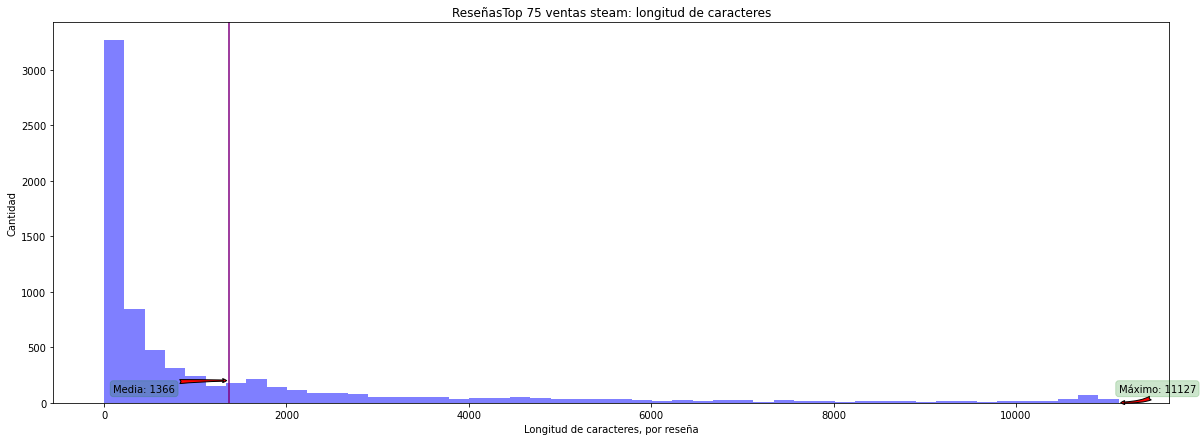

In [ ]:
#Espacio para la gráfica
fig, ax = plt.subplots(figsize=(20,7))
#Datos para graficar
ax = reviews.review.str.len().plot.hist(bins=50, alpha=0.5, color='blue')
#Linea vertical para ubicar la media
plt.axvline(x= reviews.review.str.len().mean(), ymin=0 , ymax=1, color='purple')
#Anotaciones de media y máximo
text_mean = 'Media: %d' % reviews.review.str.len().mean()
text_max = 'Máximo: %d' % reviews.review.str.len().max()

#configuración de caja de texto y flechas.
bbox = dict(boxstyle='Round', color='green', alpha=0.2, linewidth=0.9)
arrowprops = dict(facecolor='red', arrowstyle='fancy', connectionstyle='angle3')

#anotaciones de valores media y máximo
plt.annotate(text=text_mean, xy=(reviews.review.str.len().mean(), 200), xytext=(100, 100), arrowprops=arrowprops, bbox=bbox)
plt.annotate(text=text_max, xy=(reviews.review.str.len().max(), 1), xytext=(reviews.review.str.len().max(), 100), arrowprops=arrowprops, bbox=bbox)

#configuración de la gráfica
plt.title('ReseñasTop 75 ventas steam: longitud de caracteres')
plt.xlabel('Longitud de caracteres, por reseña')
plt.ylabel('Cantidad')
plt.show()

Se puede observar en la gráfica que la mayoría de las reseñas tienen muy pocos caracteres, con una media de 1366 caracteres por reseña y un máximo de hasta 11127 en algunos de los comentarios

# **Graficación por frecuencias**

Se analizan las palabras más repetidas en las reseñas de los juegos más vendidos por medio de la función Counter

In [ ]:
from wordcloud import WordCloud

In [ ]:
from collections import Counter
counter = Counter()

In [ ]:
reviews["tokens"].apply(counter.update)

0       None
1       None
2       None
3       None
4       None
        ... 
7240    None
7241    None
7242    None
7243    None
7244    None
Name: tokens, Length: 7245, dtype: object

In [ ]:
frecuencias = counter.most_common()[0:40]

In [ ]:
print(frecuencias)

[('game', 19965), ('like', 5224), ('get', 4346), ('time', 3970), ('good', 3867), ('one', 3691), ('play', 3671), ('even', 2974), ('story', 2750), ('really', 2501), ('also', 2434), ('new', 2422), ('much', 2370), ('games', 2338), ('hours', 2211), ('would', 2120), ('people', 2079), ('want', 2059), ('fun', 2056), ('still', 2038), ('make', 1919), ('well', 1916), ('playing', 1902), ('first', 1787), ('great', 1759), ('way', 1743), ('every', 1728), ('players', 1716), ('lot', 1711), ('many', 1648), ('gameplay', 1598), ('world', 1548), ('content', 1513), ('things', 1491), ('feel', 1467), ('long', 1459), ('played', 1450), ('bad', 1448), ('better', 1397), ('could', 1390)]


Se construye la nube de palabras con las palabras más relevantes en las reseñas de los videojuegos de Steam, algunas de las palabras se remueven, para que  se incluyan palabras con mayor significado

In [ ]:
def nube_palabras(corpus, stopwords, color):
    stopwords = set(stopwords)
    wordcloud = WordCloud(
        background_color=color,
        stopwords=stopwords,
        max_words=100,
        max_font_size=45,
        random_state=1)
   
    wordcloud=wordcloud.generate(str(corpus))

    fig = plt.figure(1, figsize=(15, 15))
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.show()



In [ ]:
corpus_wc = [palabra for vpalabras in reviews.tokens for palabra in vpalabras]

In [ ]:
text_wc = " ".join(palabra for palabra in corpus_wc)


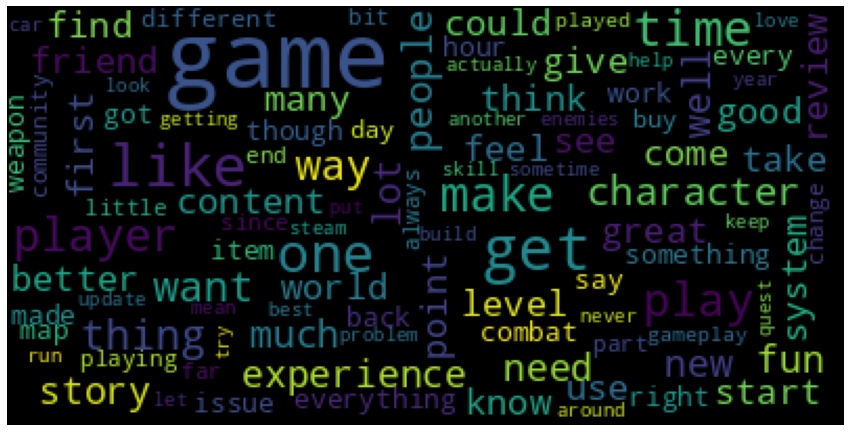

In [ ]:
nube_palabras(text_wc, ["even",'really','would','also','still','going','without','however'], "black")

#Pysentimiento

Una biblioteca basada en Transformer para tareas de SocialNLP.

Actualmente admite:

* Análisis de Sentimiento (Español, Inglés)

* Análisis de emociones (español, inglés)

* Detección de discursos de odio (español, inglés)

In [ ]:
!pip install pysentimiento

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.4/175.4 KB 5.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 69.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 469.0/469.0 KB 49.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 KB 15.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 76.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.9/132.9 KB 17.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.2/212.2 KB 28.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.8/199.8 KB 24.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 89.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 264.6/264.6 KB 30.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.8/158.8 

In [ ]:
from pysentimiento import create_analyzer

In [ ]:
sentiment_ = create_analyzer(task="sentiment", lang="en")

In [ ]:
emotions_ = create_analyzer(task="emotion", lang="en")

In [ ]:
def sentimientos(texto):
    return sentiment_.predict(texto).output

def emociones(texto):
    return emotions_.predict(texto).output

In [ ]:
reviews.head()

,review,tokens
0,"After 8 years playing it , I didn ...","[years, playing, improve, skills, game, howeve..."
1,I NOT CAN PLAY,[play]
2,Your team in every random competiti...,"[team, every, random, competitive, game, russi..."
3,This community is so nice i got ...,"[community, nice, got, lot, tips, uninstall, g..."
4,This community is so nice i got ...,"[community, nice, got, lot, tips, uninstall, g..."


In [ ]:
reviews["sentimientos"] = reviews.review.apply(sentimientos)

In [ ]:
reviews["emociones"] = reviews.review.apply(emociones)

In [ ]:
reviews.head(5)

,review,tokens,sentimientos,emociones
0,"After 8 years playing it , I didn ...","[years, playing, improve, skills, game, howeve...",POS,others
1,I NOT CAN PLAY,[play],NEG,others
2,Your team in every random competiti...,"[team, every, random, competitive, game, russi...",NEU,others
3,This community is so nice i got ...,"[community, nice, got, lot, tips, uninstall, g...",POS,others
4,This community is so nice i got ...,"[community, nice, got, lot, tips, uninstall, g...",POS,others
...,...,...,...,...
7240,Tired of getting your @$$ kicked by...,"[tired, getting, kicked, year, olds, cod, insa...",NEG,others
7241,crack in video game form,"[crack, video, game, form]",NEU,others
7242,"[ i ] A real hunter needs no prey , ...","[real, hunter, needs, prey, prey, may, definit...",NEU,others
7243,please keep solo mode on game peo...,"[please, keep, solo, mode, game, people, like,...",POS,others


<Axes: >

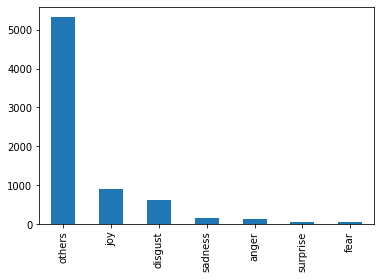

In [ ]:
reviews.emociones.value_counts().plot(kind="bar")

Puede observarse que la mayoría de las emociones expresadas en los comentarios no pueden ser clasificadas, sin embargo, la mayoría de las que si pueden serlo son emociones de alegría, lo que querría decir que muchos de los juegos más vendidos en la plataforma logran que los usuarios se expresen con alegría  en las reseñas que comparten en la plataforma, sin embargo, algunos de los usuarios expresan disgusto en sus reseñas.
Se ha observado recientemente por parte de prensa especializada, que algunos de los juegos más vendidos en distintas plataformas, tienen un gran aparato publicitario en los primeros días de lanzamiento, sin embargo, en algunos casos particulares esto no está relacionado con buenas reseñas por parte de la prensa y de los usuarios, debido a que una buena campaña publicitaria no implica que se está vendiendo un gran producto, por lo tanto, no necesariamente tendrá una buena acogida por parte de los fanáticos, esto puede influir en las expresiones de disgusto de muchos de los usuarios en la plataforma de Steam, ya que algunos de los usuarios pueden sentirse decepcionados de haber adquirido un juego que se vende como producto AAA y de gran calidad, para finalmente llevarse una gran decepción con el producto final, lo cual finalmente se expresa en las reseñas de la comunidad.
Una de las expresiones más repetidas que se observan en las reseñas es la palabra horas, que en el contexto de videojuegos se asocia con la duración de la campaña para un solo jugador, es decir, la duración de la partida es un factor importante para los usuarios para determinar si la experiencia ha sido satisfactoria o decepcionante, ya que el usuario puede expresar que la campaña le ha parecido muy corta y que su experiencia ha sido placentera, o que la experiencia se ha quedado muy corta.
 Otra de las palabras más repetidas es 'story', es decir, la historia que se cuenta en el videojuego puede ser determinante en el disfrute de la experiencia, es decir, una historia decepcionante producirá expresiones de alegría en la comunidad, y una mala historia producirá expresiones de insatisfacción o disgusto en los usuarios.
 Otra palabra importante que se repite constantemente es ´gameplay', la cual está asociada a la forma en la que se lleva a cabo la experiencia de juego, que tambien aparece por medio de la palabra 'experience', las opciones incluidas, o la forma en que se puede controlar un personaje.
 Se observa que la palabra 'bad' es casi tan abundante en las reseñas como la palabra 'better' ambas se pueden asociar a las emociones de disgusto o de alegría en los juegos.
 Se puede concluir que un juego con alto número de ventas no necesariamente será bien recibido por los usuarios, si bien, esto no necesariamente compromete las ganancias de los productos, si podría influir en la recepción de futuros títulos de alguna compañía debido a la relación con productos decepcionantes, lo cual ya se ha observado en el caso de algunos videojuegos de algunas desarrolladoras en particular, sin embargo, como se mencionó, existen factores determinantes para la opinión buena o mala sobre un producto, como son la historia, el gameplay y la duración, es notable la ausencia de palabras asociadas a la experiencia online de los videojuegos, ya que existen desarrolladoras se han enfocado en las campañas multijugador con respecto a la experiencia para una sola persona. Sin embargo, cabe mencionar que se necesita un estudio más amplio, con un mayor número de reseñas, así como un estudio para las distintas plataformas que existen, ya que el mercado de cada una de las plataformas es distinto, en este caso Steam es una de las plataformas con mayor enfoque en el usuario y tiene uno de los mejores canales de reseñas de productos, esto no necesariamente ocurre en el caso de consolas, e incluso el cliente de Microsfot, no tiene el mismo perfil que tiene un cliente de Sony o Nintendo, por lo tanto no necesariamente se pueden extender los resultados de este estudio a otras plataformas.



# huggingface:
Hugging Face, una empresa que creó por primera vez una aplicación de chat para adolescentes aburridos, ofrece tecnologías de PNL de código abierto y, el año pasado, recaudó 15 millones de dólares para crear una biblioteca de PNL definitiva. Desde su aplicación de chat hasta el día de hoy, Hugging Face ha podido desarrollar rápidamente su experiencia en el procesamiento del lenguaje.

[huggingface](https://huggingface.co/)


In [ ]:
!pip install torch==1.8.1+cu111 torchvision==0.9.1+cu111 torchaudio===0.8.1 -f https://download.pytorch.org/whl/torch_stable.html

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://download.pytorch.org/whl/torch_stable.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 GB 596.0 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.6/17.6 MB 29.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 21.0 MB/s eta 0:00:00
  Attempting uninstall: torch
    Found existing installation: torch 1.13.1+cu116
    Uninstalling torch-1.13.1+cu116:
      Successfully uninstalled torch-1.13.1+cu116
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.14.1+cu116
    Uninstalling torchvision-0.14.1+cu116:
      Successfully uninstalled torchvision-0.14.1+cu116
  Attempting uninstall: torchaudio
    Found existing installation: torchaudio 0.13.1+cu116
    Uninstalling torchaudio-0.13.1+cu116:
      Successfully uninstalled torchaudio-0.13.1+cu116
ERROR: pip's dependency resolver does not

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch

In [ ]:
modelo = "nlptown/bert-base-multilingual-uncased-sentiment"

In [ ]:
tokenizar = AutoTokenizer.from_pretrained(modelo)

In [ ]:
modelo_bert = AutoModelForSequenceClassification.from_pretrained(modelo)

In [ ]:
def hfClasificador(texto):
    tokens = tokenizar.encode(texto, return_tensors='pt', truncation = True, max_length=512)
    prediccion_m = modelo_bert(tokens)
    if len(texto)>512:
        texto = texto[:512]
      
    return torch.argmax( prediccion_m.logits).item() +1

In [ ]:
reviews["stars"] = reviews.review.apply(hfClasificador)

In [ ]:
reviews.head()

,review,tokens,sentimientos,emociones,stars
0,"After 8 years playing it, I didn't improve my ...","[years, playing, improve, skills, in-game, how...",POS,others,5
1,I NOT CAN PLAY,[play],NEG,others,1
2,Your team in every random competitive game: -...,"[team, every, random, competitive, game, russi...",NEU,others,5
3,This community is so nice i got a lot of tips ...,"[community, nice, got, lot, tips, uninstall, g...",POS,others,5
4,This community is so nice i got a lot of tips ...,"[community, nice, got, lot, tips, uninstall, g...",POS,others,5


<Axes: >

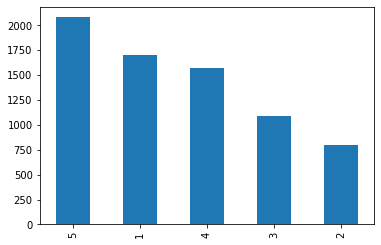

In [ ]:
reviews.stars.value_counts().plot(kind="bar")

En la clasificación por medio de estrellas puede confirmarse la tendencia que se observó en el caso de las emociones, los usuarios que expresan completa satisfacción con los productos, son casi el mismo número de los que expresan insatisfacción, debidos a los factores mencionados anteriormente

<Axes: >

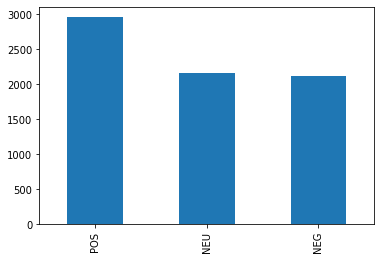

In [ ]:
reviews.sentimientos.value_counts().plot(kind="bar")

Es importante mencionar que la mayoría de los sentimientos observados en los comentarios de los usuarios son positivos, sin embargo, la suma de los neutros y negativos es mayor que el número de comentarios positivos, este hecho quizás no es relevante en algunas plataformas, sin embargo, el usuario promedio de la plataforma Steam suele tomar en cuenta las opiniones de la comunidad a la hora de llevar a cabo una compra, sin embargo, se recomienda un estudio para un mayor número de reseñas.
En conclusión se puede decir que se observaron factores determinantes en la acogida de un producto en la comunidad de jugadores de PC que son usuarios de la plataforma Steam, por lo tanto esto puede ayudar a decidir a la plataforma los títulos que debe atraer a su catálogo para lograr un buen número de ventas y la satisfacción del usuario, que es uno de los pilares de la filosofía de esta plataforma